###### Emil Carvajal Viteri - 1529821

# Aprenentatge Computacional:  Classificació d'URL

### 1. Introducció

Aquesta pràctica consisteix en l'ànilisis d'una base de dades de URL's on finalment es crearan models classificatoris a partir de les paraules clau d'aquestes URL.

Aquesta base de dades és: https://www.kaggle.com/shawon10/url-classification-by-naive-bayes/data

### Procés
* Manipulació i visualització de les dades del dataset.
* Pre-procesament de les dades i extracció de paraules clau.
* Subsampling de les classes majoritàries.
* Selecció, execució i comparació de diversos models classificadors. 
* Anàlisis de mètriques, curves ROC i PRC.

### 2. Dataset

In [173]:
# Importem llibreries

import ipywidgets as widgets
from sklearn.datasets import make_regression
import numpy as np
import pandas as pd
%matplotlib notebook
from matplotlib import pyplot as plt
import scipy.stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np #importem la llibreria
import random

Per començar, carregarem la base de dades. Tot seguit, farem que només es puguin visualitzar les dades fins a 3 decimals i mirarem la dimensionalitat dels atributs.


In [174]:
# Visualitzarem només 3 decimals per mostra en les taules
pd.set_option('display.float_format', lambda x: '%.3f' % x)

names=['URL','Category'] #Columnes base de dades

# Funcio per a llegir dades en format csv

def load_dataset():
    path = 'URL_Classification.csv'
    dataset=pd.read_csv(path,names=names, na_filter=False)
    return dataset

# Carreguem dataset asignat
dataset = load_dataset()
data = dataset.values

Ara visualitzarem la dimensionalitat del dataset, les entrades i les sortides.

La sortida fa referència a la variable objectiu. En aquesta base de dades de URL's la variabe objetiu és el tipus de categoria que corresponenen les URL's. Això es degut a que no hi han més característiques en aquesta base de dades.

Per tant és la única variable a estudiar. 

In [175]:
x = data[:, 0]
y = data[:,1]

print("Dimensionalitat de la BBDD:", dataset.shape)
print("Dimensionalitat de les entrades X", x.shape)
print("Dimensionalitat de l'atribut Y", y.shape)

Dimensionalitat de la BBDD: (1562978, 2)
Dimensionalitat de les entrades X (1562978,)
Dimensionalitat de l'atribut Y (1562978,)


#### Tipus
Ara mirem el tipus de variable de cada atribut per saber com tractar les dades.

In [176]:
print(dataset.dtypes)

URL         object
Category    object
dtype: object


Tenim la URL i la seva categoria de tipus object que son cadenes.

#### Valors nulls o duplicats
Abans de tractar el dataset ens hem d'asegurar que no existeixen valors nulls o duplicats que ens fagin obtenir un estudi erroni.

In [177]:
print(dataset.isnull().sum())

URL         0
Category    0
dtype: int64


Com no existeixen valors nulls no ens cal modificar la base de dades.

In [178]:
dataset = dataset.drop_duplicates()

Si hi han valors duplicats els eliminem.

#### Visualitzem les 5 primeres instàncies:


In [179]:
dataset.head()

,URL,Category
1,http://www.liquidgeneration.com/,Adult
2,http://www.onlineanime.org/,Adult
3,http://www.ceres.dti.ne.jp/~nekoi/senno/senfir...,Adult
4,http://www.galeon.com/kmh/,Adult
5,http://www.fanworkrecs.com/,Adult


#### Obtenim lista de categories


In [180]:
l_categories = []
for c in dataset["Category"]:
    if c not in l_categories:
        l_categories.append(c)
print(l_categories)

['Adult', 'Arts', 'Business', 'Computers', 'Games', 'Health', 'Home', 'Kids', 'News', 'Recreation', 'Reference', 'Science', 'Shopping', 'Society', 'Sports']


#### Calcular les estadístiques generals.


No és necessari ja que com hem vist totes les entrades son cadenes.



#### Visualitzem nº elements de totes les categories


<IPython.core.display.Javascript object>


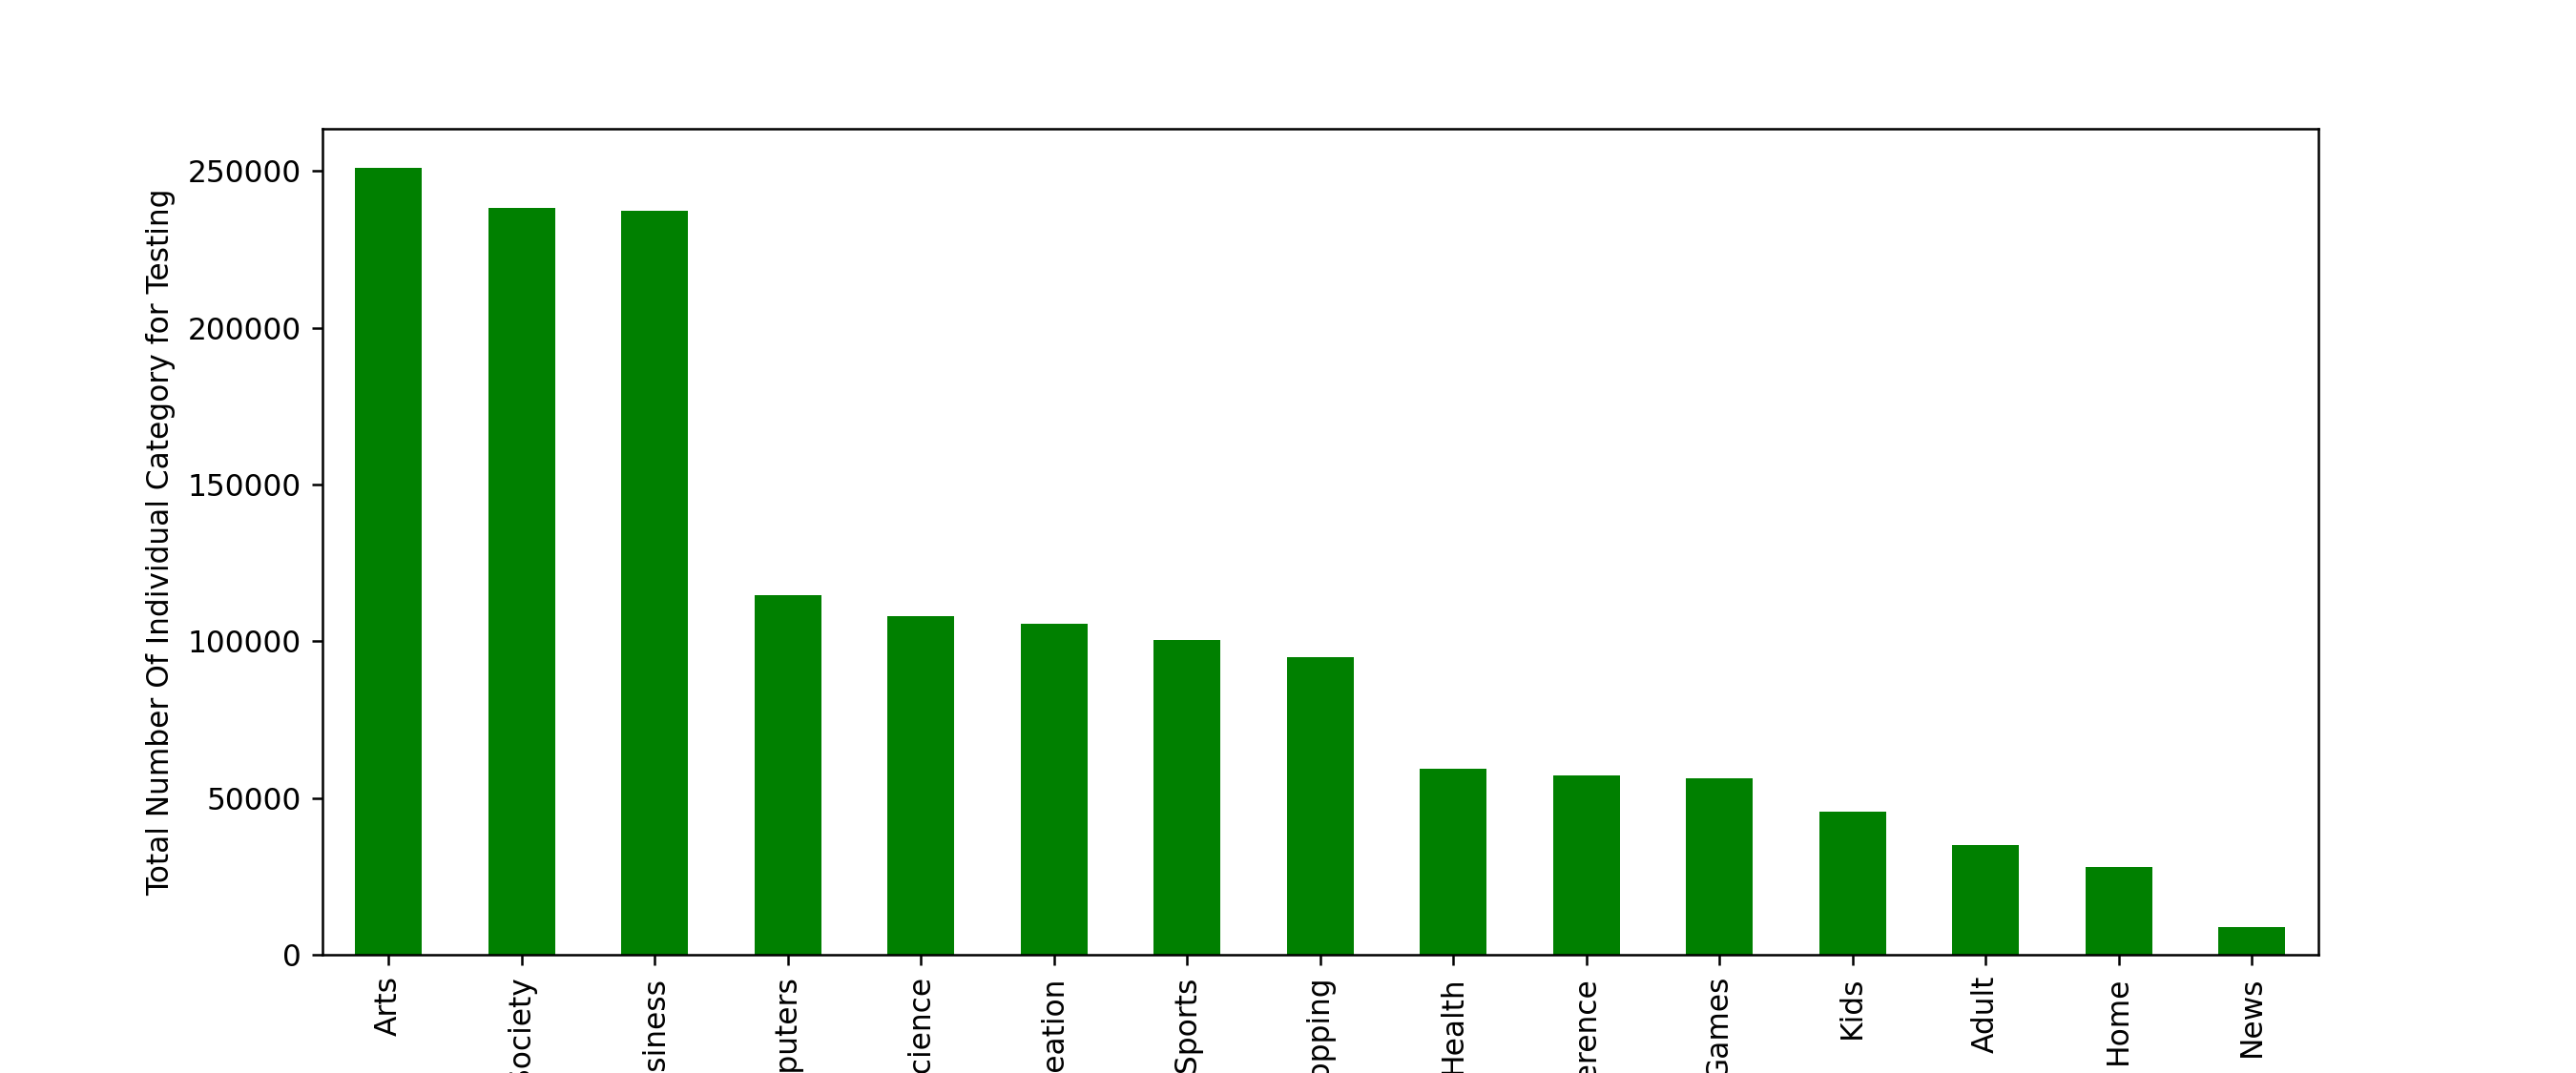

Text(0, 0.5, 'Total Number Of Individual Category')

In [181]:
dataset.Category.value_counts().plot(figsize=(12,5),kind='bar',color='green');
plt.xlabel('Category')
plt.ylabel('Total Number Of Individual Category')

In [182]:
dataset.Category.value_counts()

Arts          250909
Society       238324
Business      237359
Computers     114582
Science       107912
Recreation    105465
Sports        100360
Shopping       94998
Health         59436
Reference      57105
Games          56218
Kids           45799
Adult          35123
Home           28047
News            8848
Name: Category, dtype: int64

Observem que tenim  categories desbalancejades, es a dir, amb moltes més instàncies que altres. La que menys instàncies té és la categoria "News" (8989) i la que més és "Arts" (253840). Això pot dificultar l'aprenentatge i la predicció de les categories amb poques dades.

#### Dividim dataset per categories

In [183]:
d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14 = 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
def div_dataset_by_Category():
  global d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14
  d0 = dataset[dataset['Category'].values =='Adult']
  d1 = dataset[dataset['Category'].values =='Arts']
  d2 = dataset[dataset['Category'].values =='Business']
  d3 = dataset[dataset['Category'].values =='Computers']
  d4 = dataset[dataset['Category'].values =='Games']
  d5 = dataset[dataset['Category'].values =='Health']
  d6 = dataset[dataset['Category'].values =='Home']
  d7 = dataset[dataset['Category'].values =='Kids']
  d8 = dataset[dataset['Category'].values == 'News']
  d9 = dataset[dataset['Category'].values =='Recreation']
  d10 = dataset[dataset['Category'].values =='Reference']
  d11 = dataset[dataset['Category'].values =='Science']
  d12 = dataset[dataset['Category'].values =='Shopping']
  d13 = dataset[dataset['Category'].values =='Society']
  d14 = dataset[dataset['Category'].values =='Sports']

Ja que el dataset està ordenat per categories, dividim totes les instàncies segons la seva categoria. Això ho fem per poder poder distribuir les dades i tenir exemples de totes les categories tant en el train com en el test. Això ho podriem fer de forma aleatoria però com tenim categories desbalancejades podria donar-se el cas d'entrenar un model amb molt poques instàncies d'una categoria o inclús sense cap instància.

### Funcións per reduir el tamany del dataset

In [185]:
from sklearn.model_selection import train_test_split

#forma 1
def train_test_from_data(tz,d_list,n_instancias):
    data_train = 0
    data_test = 0
    c = 0
    for data in d_list:
        long = int(len(data)*n_instancias)
        data = data[:long]
        if c == 0:
            tra, tes = train_test_split(data, test_size=tz) #train, test
            data_train = tra
            data_test = tes
        else:
            tra, tes = train_test_split(data, test_size=tz) #train, test
            data_train=pd.concat([data_train, tra],axis=0)
            data_test=pd.concat([data_test, tes],axis=0)
        c=1
    #print("lenedd dx: ",data_train.shape)
            
    return data_train, data_test


Aquesta funció permet reduir el dataset de forma proporcional al nombre total de instancies de cada categoria. Daquesta manera manipulem datasets més petit amb dades proporcionals a l'original. Aquesta funció es feia servir inicialment per fer les primeres proves amb un dataset més petit però es va descartar per l'idea de fer sub-sampling. 


In [186]:
def subData(d_list, dataSize):
    data_train = 0
    data_test = 0
    c = 0
    for data in d_list:
        #long = int(len(data)*dataSize)
        #data = data.sample(long)
        data = data[:dataSize]
        if c == 0:
            subData = data
        else:
            subData=pd.concat([subData, data],axis=0)
        c=1
    #print("lenedd dx: ",data_train.shape)
            
    return subData

Aquesta funció permet reduir el dataset segons el nombre d'instàncies que volem de cada categoria. És la funció que farem servir per no tractar amb tot el dataset.

## 3. Preparació de les dades 

Dividim dataset per categores

In [187]:
div_dataset_by_Category()

### Disminuim dataset

In [188]:
#tz = 0.019189 # tz = 0.019189
n_instancias = 10000
d_list = [d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14]

#data_train, data_test =  train_test_from_data1(tz,d_list,n_instancias)
Data = subData(d_list,n_instancias)

# TRAIN
X_data= Data['URL']
Y_data= Data['Category']


In [189]:
Data

,URL,Category
1,http://www.liquidgeneration.com/,Adult
2,http://www.onlineanime.org/,Adult
3,http://www.ceres.dti.ne.jp/~nekoi/senno/senfir...,Adult
4,http://www.galeon.com/kmh/,Adult
5,http://www.fanworkrecs.com/,Adult
...,...,...
1471699,http://www.usatoday.com/sports/basketba/skw/ma...,Sports
1471700,http://sports.excite.com/wcbk/teams/135/index....,Sports
1471701,http://www.canisius.edu/athletics/teams/team.a...,Sports
1471702,http://sportsillustrated.cnn.com/basketball/co...,Sports


#### Perquè 10.000 instancies de màxim per cada categoria?

Després de múltiples proves amb diferents tamanys del dataset i diverses funcions per fer resampling, he dicidit balancejar les dades manualment amb tamany proper a la categoria amb menys dades, que és la categoria "News" amb 8848. Això es així ja que els resultats obtinguts amb funcions de resampling no han sigut gaire bons e inclús alhora de fer reampling amb tota la base de dades he tingut problemes de memoria. Per estalviar temps i recursos e inclús aconseguir millors resultats el nombre estable es el de 10.000 ja que utilitzant 20.000, 30.000... els resultats no milloraben i es consumia més temps.

In [197]:
dataset.Category.value_counts().plot(figsize=(12,5),kind='bar',color='green');
plt.xlabel('Category')
plt.ylabel('Total Number Of Individual Category for Testing')

Text(183.875, 0.5, 'Total Number Of Individual Category for Testing')

In [193]:
Data.Category.value_counts()

Adult         10000
Arts          10000
Business      10000
Computers     10000
Games         10000
Health        10000
Home          10000
Kids          10000
Recreation    10000
Reference     10000
Science       10000
Shopping      10000
Society       10000
Sports        10000
News           8848
Name: Category, dtype: int64

Com podem observar ara el dataset està molt més balancejat.

### Obtenim paraules clau

Funció extract_words

In [198]:
import re
import wordninja

def extract_words(url):
    #url = "http://genetik.fu-berlin.de/instengl_234abeja12Caca/indexEngl.html"
    url = ''.join(i for i in url if not i.isdigit())
    domain = url.split('//')[-1].split('/')

    # Dividim quan trobem majúscules
    a=[]
    for x in domain:
        if a ==[]:
            a= re.sub( r"([A-Z])", r" \1", x).split()
        else:
            a = a+ re.sub( r"([A-Z])", r" \1", x).split()

    # Dividim a partir de caràcters especials
    df = [] 
    for x in a:
        if df == []:
            df = re.split(r'[`\-=~!@#$%^&*()_+\[\]{};\'\\:"|<,./<>?]', x)
        else:
            df+=  re.split(r'[`\-=~!@#$%^&*()_+\[\]{};\'\\:"|<,./<>?]', x)
    
    # Eliminem paraules que no ens ajuden a apendre
    r = ["html", "www","com","net","htm","php","engl"]
    for rr in r:
        if rr in df:
            df.remove(rr)
   
    
    df = " ".join(df)
    df= wordninja.split(df)
    df = [x for x in df if len(x)>2 ]
    df = " ".join(df)
    #print(df)
    return df

Aquesta funció permet extreure les paraules clau que les URL. D'aquesta manera fem una neteja de tots els caràcters, números i paraules que no ens ajuden en l'aprenentage. Un cop tenim les paraules separades s'utilitza la llibreria "wordninja" per exterure les paraules d'una cadena unida. 
Exemple (tablechair door) -> (table chair door)

In [201]:
url = "http://genetik.fu-berlin.de/instengl_234bee12Shit/apru=234_ala?house/indexEngl.html"
extract_words(url)

'gene tik berlin engl bee Shit apr house index Engl'

##### Apliquem funció al dataset

In [202]:
X_data_p = X_data.apply(lambda x: extract_words(x))

In [203]:
X_data_p.sample(20)

1219331                             one wal albert anastasia
957750                                                      
846773                              angel fire the reservoir
650917                                      para seek arcade
500                                              xxx funnies
648866                                   boardgame geek game
538223                                                   pdf
792662     jay easton galleries clarinet family clarinet ...
39173                                      ameno miko tripod
963153                                             johns org
649758                                         tah dah games
1464312                                  cubs forum blogspot
1131750                                               wright
7524                      atlant its large tits francine dee
55                                   car nate boys next door
293512                                                   sni
1469512                 

Hem obtingut les paraules relevants de totes les URL's eliminant caràcters i paraules que no ens interesen per l'aprenentatge i així aconseguir millors resultats.

### Partim en Train i Test

Dividim les dades en 80% train i 20% test

In [207]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from imblearn.under_sampling import NearMiss
from collections import Counter

In [208]:
# La X son les URL amb les paraules clau i la Y la seva classificació.

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X_data)
y = Y_data

# SUBSAMPLING  no implementat al final. Fet manualment
# Com les dades estan desbalancejades, el que farem és fer servir un algoritme per reduir les classes majoritàries.
#Ho farem utilitzant un algoritme que funciona similar al k-nearest neighbor per anar seleccionant quins eliminar.
#us = NearMiss( n_neighbors=3, version=2)
#X_data_res, Y_data_res = us.fit_resample(X, y)
 
#print ("Distribution before resampling {}".format(Counter(Y_data)))
#print ("Distribution after resampling {}".format(Counter(Y_data_res)))

# Separem les dades en els conjunts de train i test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# Unable to allocate 1.00 GiB for an array with shape (15169, 8848) and data type int64

## 3. Selecció de model

**Per poder classificar les URL considerarem les seguents tècniques d'aprenentatge computacional:**
* SVM
* NN
* Regressió logística
* Naive Bayes

Hem triat aquestes tècniques ja que són tècniques clasificatories i el que volem aconseguir és clasificar les URL segons els seu contingut (Adult, News, Sport...)

* SVM 

Els kernels, en els models de SVM, ens poden ajudar a clasificar correctament les dades que no es poden divir en hiperplans agregant dimensions a l'espai. Considerarem el kernels de "linear".

* NN

Els models que implemente la tècnica "Nearest Neighbour" clasifiquen un nou objecte en funció dels objectes que l'envolten. Si la majoria d'aquests objectes perteneixen a la categoria "x", si li asigna aquesta categoria al nou objecte. Aquest concepte és molt interesant en el nostre cas.

* Regressió logística

Aquesta tècnica es basa en la funció logística la qual es basa en les probabilitats i un llindar per clasificar. Pot ser util alhora de classificar un atribut categòric ordinari, just el que volem fer amb la nostra BD.

* Naive Bayes

L'algorisme classificador Naïve-Bayes (NBC) és un classificador probabilístic simple amb forta suposició d'independència. Encara que la suposició de la independència dels atributs és generalment una suposició pobra i es viola sovint pels conjunts de dades veritables. Sovint proporciona una millor precisió de classificació en conjunts de dades a temps real que qualsevol altre classificador.

## 4. Aplicació de models i evaluació  

In [209]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Importació de models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Declaració de models
logisticRegression = LogisticRegression(C=0.01, fit_intercept=True, penalty='l2', tol=0.001)
naiveBayes = MultinomialNB()
SVM = SVC(kernel='linear', C=0.1, gamma=0.9, probability=True)
knn = KNeighborsClassifier(20) # 20 veins

models = [logisticRegression, naiveBayes, SVM, knn]
l_matrix = []
l_accuracy = []
l_reports = []

for model in models:
    print("Entrenant model: ",model)
    model.fit(X_train, y_train)
    # Predicció 
    pred = model.predict(X_test)
    accuracy  = round(accuracy_score(y_test, pred)*100)
    report = classification_report(y_test, pred)

    l_accuracy.append(accuracy )
    l_reports.append(report)

Entrenant model:  LogisticRegression(C=0.01, tol=0.001)
Entrenant model:  MultinomialNB()
Entrenant model:  SVC(C=0.1, gamma=0.9, kernel='linear', probability=True)
Entrenant model:  KNeighborsClassifier(n_neighbors=20)


In [210]:
from tabulate import tabulate
info = {'Model': ['logisticRegression','Naive Bayes', 'Naive Bayes', 'Knn'], 'Accuracy': l_accuracy}
print(tabulate(info, headers='keys', tablefmt='fancy_grid'))

╒════════════════════╤════════════╕
│ Model              │   Accuracy │
╞════════════════════╪════════════╡
│ logisticRegression │         37 │
├────────────────────┼────────────┤
│ Naive Bayes        │         48 │
├────────────────────┼────────────┤
│ SVM                │         42 │
├────────────────────┼────────────┤
│ knn                │         36 │
╘════════════════════╧════════════╛


#### Resultats

In [258]:
import seaborn as sns
def mostrar_resultados(l_reports):
    i=0
    for x in l_reports:
        print (models[i])
        print (x)
        print ("------------------------------------------------------")
        i+=1

In [259]:
mostrar_resultados(l_reports)

LogisticRegression(C=0.01, tol=0.001)
              precision    recall  f1-score   support

       Adult       0.65      0.35      0.45      1970
        Arts       0.43      0.65      0.51      2000
    Business       0.38      0.08      0.14      1968
   Computers       0.57      0.17      0.26      1989
       Games       0.17      0.13      0.15      2015
      Health       0.39      0.07      0.12      1928
        Home       0.48      0.62      0.54      1991
        Kids       0.83      0.58      0.68      2007
        News       0.42      0.12      0.18      1813
  Recreation       0.22      0.17      0.19      2026
   Reference       0.62      0.58      0.60      2042
     Science       0.38      0.40      0.39      2076
    Shopping       0.15      0.73      0.26      1978
     Society       0.20      0.21      0.21      1968
      Sports       0.93      0.59      0.72      1999

    accuracy                           0.37     29770
   macro avg       0.45      0.36      0.3

Com podem obervar en aquesta execució (perquè s'han fet varies amb resultats millors però aquesta s'ha deixat com a final per no provar més execucions ja que alguns models com el SVC o el KNN consumeixen moltes hores) els resultats no son gaire bons. Com ha molt s'ha arribat a obtenir un 48% d'accuracy en el Naive Bayes. Això podria significar que o necessitem més dades de cada categoria o que en el procés d'obtenció de paraules clau s'haurien d'obtenir paraules encara més precises.

### 5. Anàlisi de model i mètriques

#### Naive Bayes

Ara evaluarem més en profunditat un dels métodes que més presició hem obtingut, que es el Naive Bayes.

Primer el tornarem a executar.

In [220]:
n_instancias = 10000
d_list = [d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14]

Dataa = subData(d_list,n_instancias)

X_data= Dataa['URL']
Y_data= Dataa['Category']

In [221]:
Dataa.Category.value_counts()

Adult         10000
Arts          10000
Business      10000
Computers     10000
Games         10000
Health        10000
Home          10000
Kids          10000
Recreation    10000
Reference     10000
Science       10000
Shopping      10000
Society       10000
Sports        10000
News           8848
Name: Category, dtype: int64

In [222]:
Dataa.shape

(148848, 2)

In [223]:
X_data_w = X_data.apply(lambda x: extract_words(x))

In [262]:
vectorizer = CountVectorizer()
XX = vectorizer.fit_transform(X_data_w)
yy = Y_data

# Separem les dades en els conjunts de train i test:
X_train2, X_test2, y_train2, y_test2 = train_test_split(XX, yy, test_size=0.2, random_state=100)

In [263]:
models = [naiveBayes]
for model in models:
    print("Entrenant model: ",model)
    model.fit(X_train2, y_train2)
    pred = model.predict(X_test2)
    accuracyy  = round(accuracy_score(y_test2, pred)*100)
    print("accuracyy: ",accuracyy)

Entrenant model:  MultinomialNB()
accuracyy:  59


Observem que en aquesta execució amb parametres similiars l'accuracy a aumentat de forma significativa( 48 ->59 )

Ara executarem el model amb varies particions de Train

In [274]:
n_classes = 15
    
#fig, sub = plt.subplots(1, 2, figsize=(16,6))
#sub[0].scatter(X[:,0], Y, c=Y, cmap=plt.cm.coolwarm, edgecolors='k')
#sub[1].scatter(X[:,1], Y, c=Y, cmap=plt.cm.coolwarm, edgecolors='k')

particions = [0.5, 0.7, 0.9]

for part in particions:
    x_t, x_v, y_t, y_v = train_test_split(XX, yy, train_size=part)

    # l'entrenem 
    naiveBayes.fit(x_t, y_t)
    probs = naiveBayes.predict_proba(x_v)
    print ("Correct classification Naive Bayes      ", part, "% of the data: ", naiveBayes.score(x_v, y_v))

Correct classification Naive Bayes       0.5 % of the data:  0.5798801461894013
Correct classification Naive Bayes       0.7 % of the data:  0.6002015451797111
Correct classification Naive Bayes       0.9 % of the data:  0.6004702720859926


Observem que obtenim un accuracy similar encara que variem els percentatges de Train i Test.

#### Curves ROC i PRC

Ara visualitzarem i analitzarem les curves ROC i PCR de l'última execució.

<IPython.core.display.Javascript object>


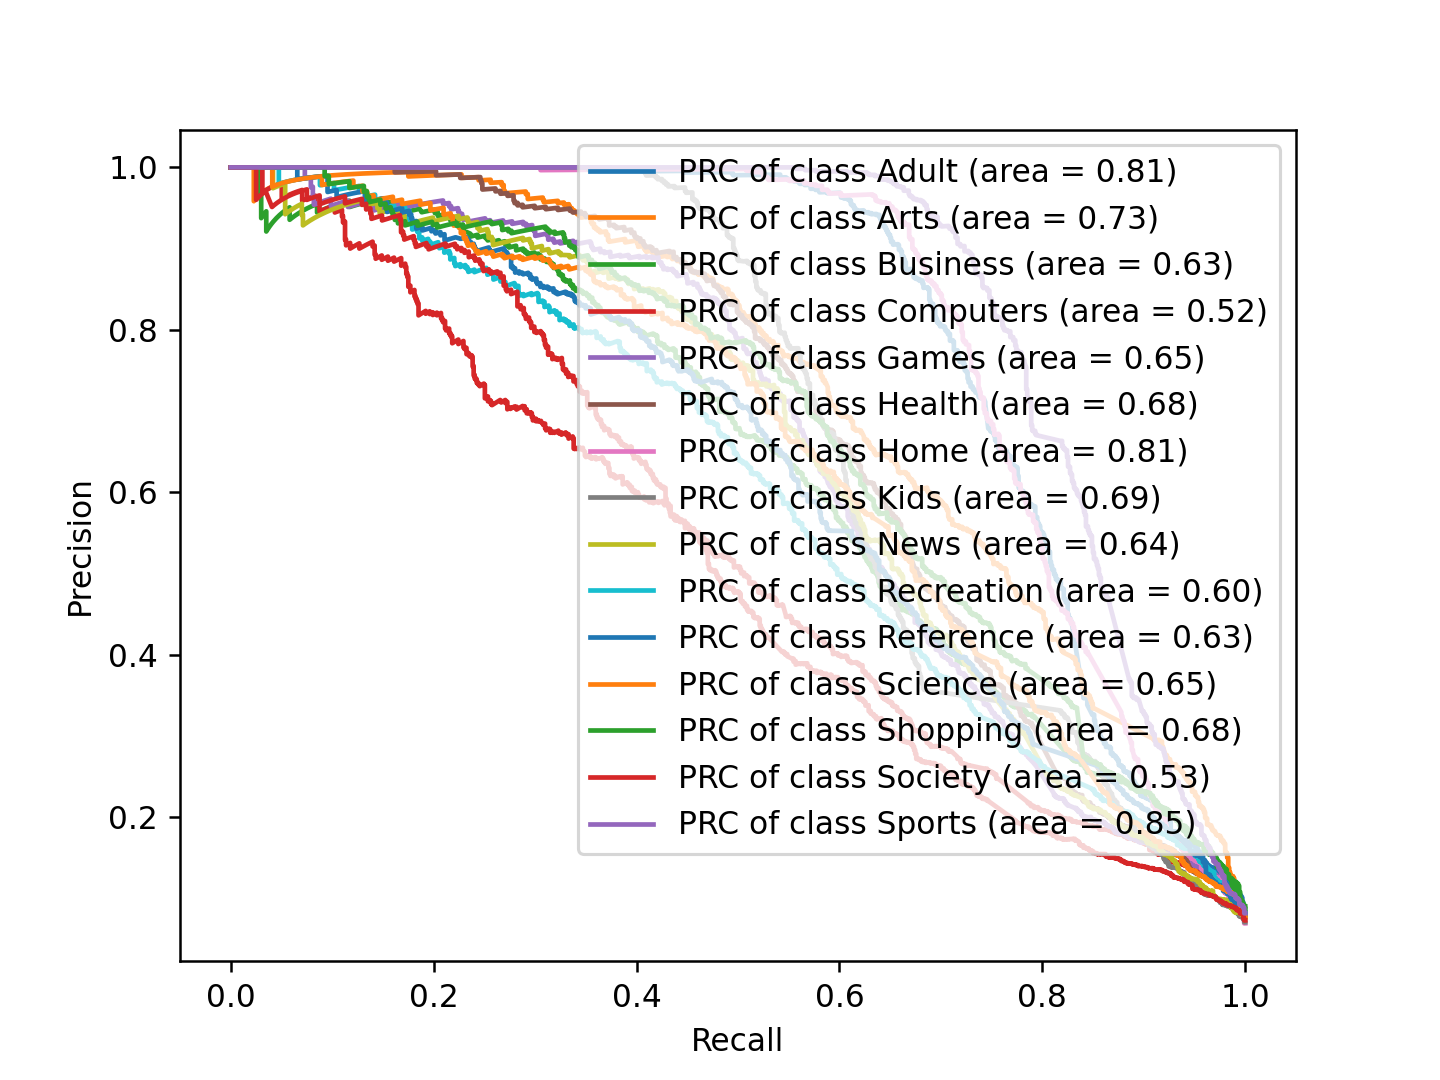

<IPython.core.display.Javascript object>


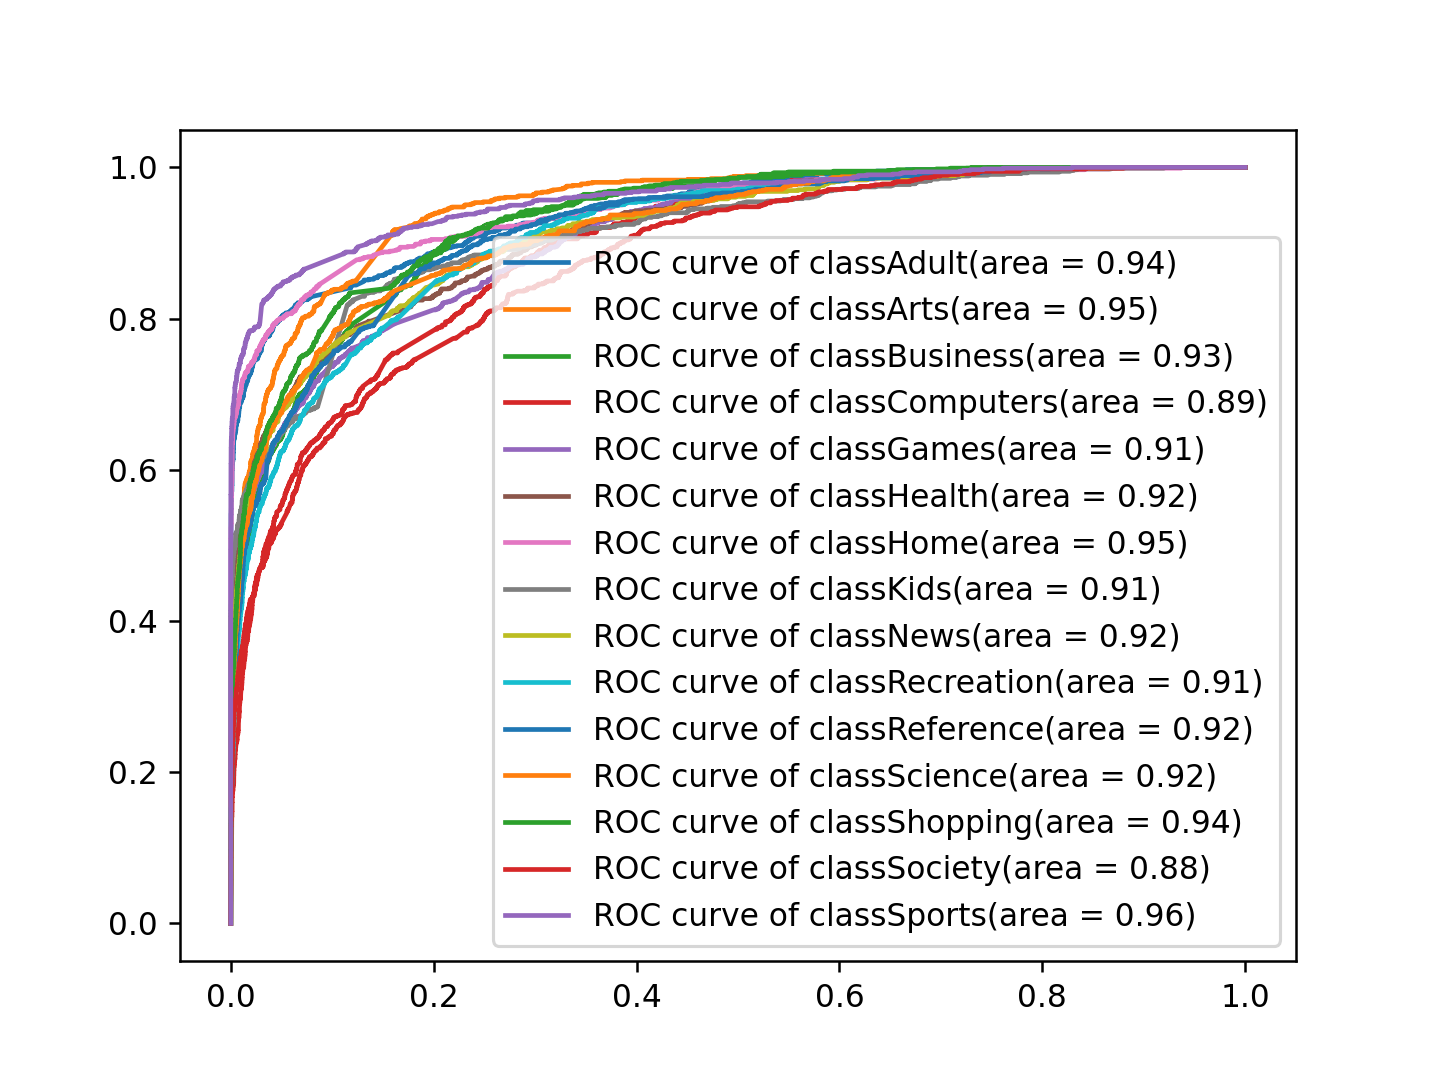

In [290]:
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, roc_curve, auc

# Compute Precision-Recall and plot curve
precision = {}
recall = {}
average_precision = {}
plt.figure()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_v == l_categories[i], probs[:, i])
    average_precision[i] = average_precision_score(y_v == l_categories[i], probs[:, i])

    plt.plot(recall[i], precision[i],
    label='PRC of class '+l_categories[i]+' (area = {1:0.2f})'
                           ''.format(i, average_precision[i]))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="upper right")

    
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_v == l_categories[i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
# Plot ROC curve
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class'+l_categories[i]+'(area = {1:0.2f})' ''.format(i, roc_auc[i]))
plt.legend()

Com podem observar, al no tenir molta accuracy , en la gràfica de precision-recall poques classes estàn ubicades pròximes al 1 (més àrea en les curves) que és el que estem buscant ja que ens informa sobre la ràtio o percentatge de classificacions correctes del nostre classificador. 

La curva roc també és propera al 1 en general pero no en totes les clases. Aquesta curva relaciona el recall amb la ràtio de falsos positius i així aconseguim més àrea en les curves.

## 6. Conclusions

##### Procés
    * Hem vist com manipular i visualitzar les dades d'un dataset.
    * Hem pre-processat les dades i hem extret les paraules clau de les URL.
    * Hem afrontat un problema de desbalancejament de dades amb mètodes de Subsampling de les classes majoritàries.
        * S'han tingut problemes de memòria per processar tot el dataset ja que el seu tamany és enorme (+1.5 Millions d'instancies).
    * Hem seleccionat, executat i comparat diversos models per un problema de classificació. 
        * D'aquests el més precís ha sigut el model Naive Bayes.
    * Per últim hem treballat més a fons el model Naive Bayes i hem visualitzat les curves ROC i PCR d'una execució.
        * En aquestes curves, en general, hem obtingut un àrea propera a 1.
    

##### Presició de models:
    * Com ha molt s'ha arribat a obtenir un 59% d'accuracy en el Naive Bayes. Això podria significar que o necessitem més dades de cada categoria o que en el procés d'obtenció de paraules clau s'haurien d'obtenir paraules encara més precises. 
    * També es podria obtenir millors resultats modificant alguns hyperparàmetres dels models amb menys presició obtingunda o fer un resampling de totta la base de dades diferent a l'utilitzat.
